
# A Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da
un dato acquisito mediante il seguente modello:

$$b = Ax + η (1)$$

dove $b$ rappresenta l’immagine corrotta, $x$ l’immagine originale che vogliamo
ricostruire, $A$ l’operatore che applica il blur Gaussiano ed $η$ il rumore additivo
con distribuzione Gaussiana di media 0 e deviazione standard $σ$.


## Esercizio 1
1. Caricare l’immagine `camera()` dal modulo `skimage.data`, rinormalizzandola nel range $[0, 1]$.
2. Applicare un blur di tipo gaussiano con deviazione standard $3$ il cui kernel
ha dimensioni $24 × 24$ utilizzando le funzioni fornite `gaussian_kernel()`,
`psf_fft()` ed `A()`.
3. Aggiungere rumore di tipo gaussiano, con deviazione standard $0.02$, usando la funzione `np.random.normal()`.
4. Calcolare il *Peak Signal Noise Ratio* (PSNR) ed il *Mean Squared Error*
(MSE) tra l’immagine degradata e l’immagine originale usando le funzioni `peak signal noise ratio` e `mean squared error` disponibili nel modulo `skimage.metrics`

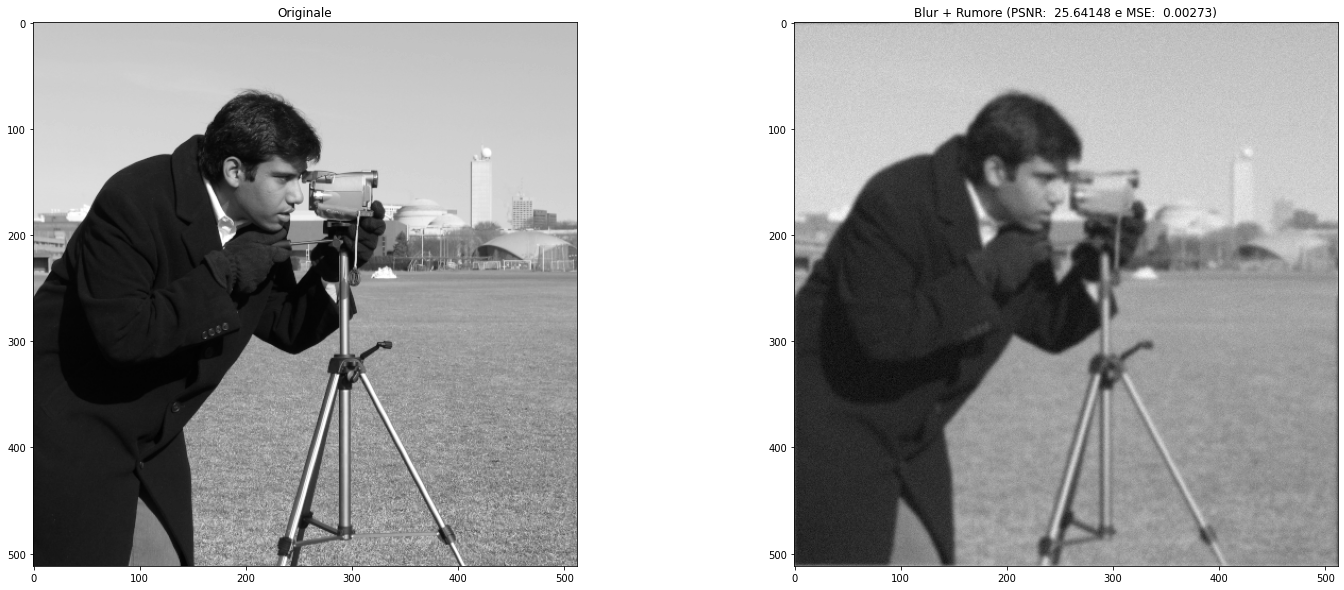

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
from scipy.optimize import minimize

np.random.seed(0)

# Crea un kernel Gaussiano di dimensione kernlen e deviazione standard sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Kernel gaussiano unidmensionale
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Kernel gaussiano bidimensionale
    kern2d = np.outer(kern1d, kern1d)
    # Normalizzazione
    return kern2d / kern2d.sum()

# Esegui l'fft del kernel K di dimensione d agggiungendo gli zeri necessari 
# ad arrivare a dimensione shape
def psf_fft(K, d, shape):
    # Aggiungi zeri
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Sposta elementi
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Esegui FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Moltiplicazione per A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Moltiplicazione per A trasposta
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

X = data.camera().astype(np.float64) / 255.0
m, n = X.shape

# Genera il filtro al blur
K = psf_fft(gaussian_kernel(9, 3), 9, X.shape)

# Genera il rumore
sigma = 0.02 # Tra 0.001 e 0.1, più si va verso gli estremi meno/più 
noise = np.random.normal(0, sigma, size = X.shape)

# Aggiungo blur e noise
b = A(X, K) + noise

PSNR = metrics.peak_signal_noise_ratio(X, b)
MSE = metrics.mean_squared_error(X, b)

plt.figure(figsize = (25, 10))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(X, cmap = 'gray')
plt.title('Originale')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(b, cmap = 'gray')
plt.title(f'Blur + Rumore (PSNR: {PSNR: .5f} e MSE: {MSE: .5f})')

plt.show()

# B Soluzione naive
Una possibile ricostruzione dell’immagine originale $x$ partendo dall’immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:

$$x^∗ = arg min_x \frac{1}{2}||Ax - b||^2_2$$

La funzione $f$ da minimizzare è data dalla formula

$$f (x) = \frac{1}{2} ||Ax − b||^2_2$$

il cui gradiente $∇f$ è dato da

$$∇f (x) = A^T Ax − A^T b$$


## Esercizio 2
1. Utilizzando il metodo del gradiente coniugato implementato dalla funzione
`minimize`, calcolare la soluzione naive.
2. Analizza l’andamento del PSNR e dell’MSE al variare del numero di iterazioni.

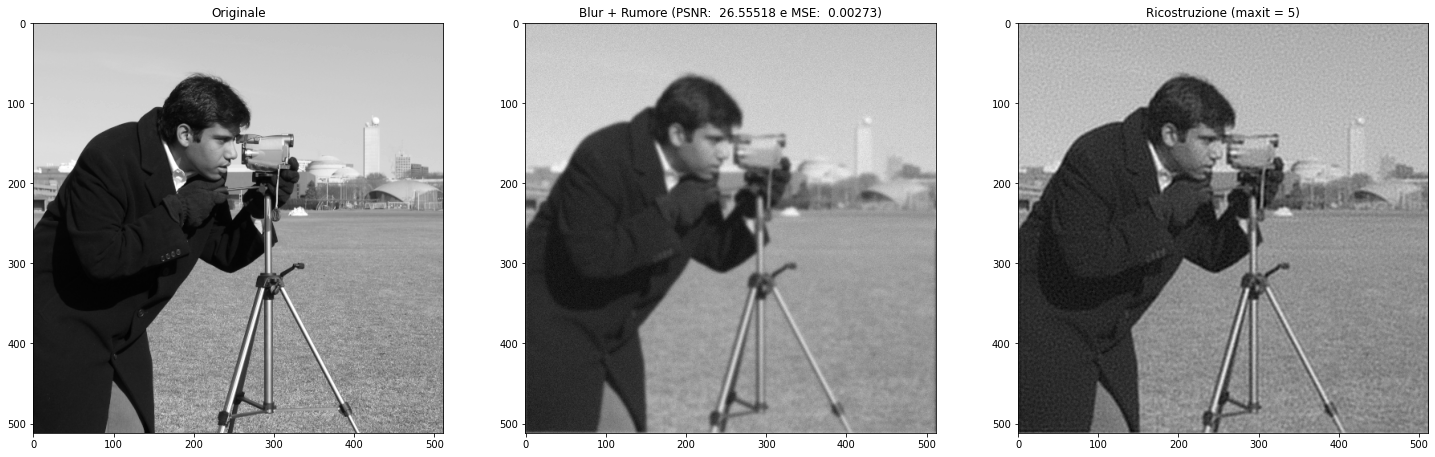

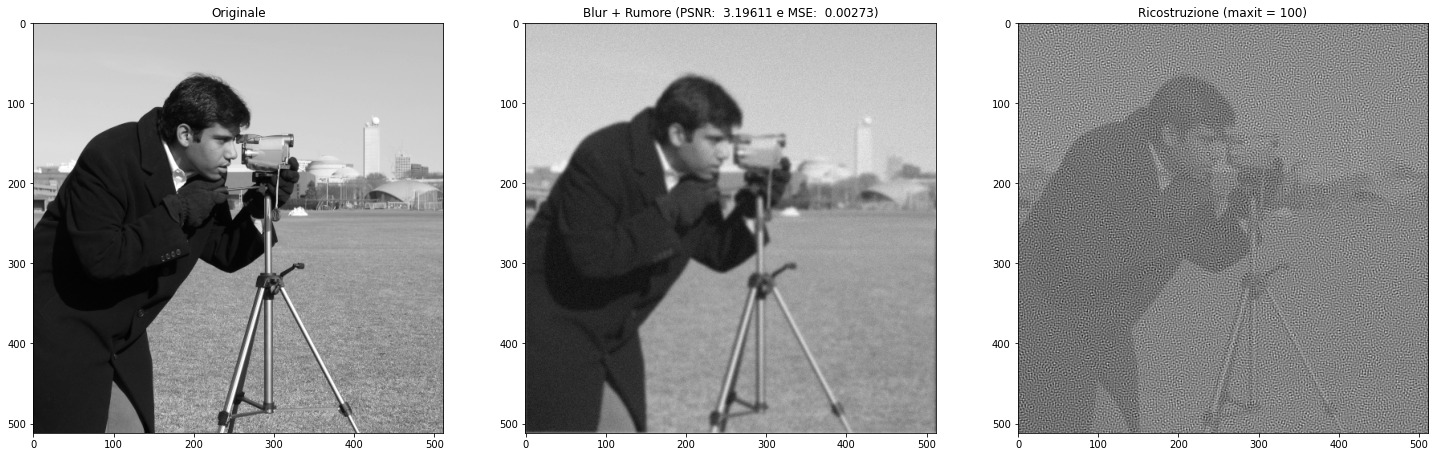

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
from scipy.optimize import minimize

np.random.seed(0)

# Crea un kernel Gaussiano di dimensione kernlen e deviazione standard sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Kernel gaussiano unidmensionale
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Kernel gaussiano bidimensionale
    kern2d = np.outer(kern1d, kern1d)
    # Normalizzazione
    return kern2d / kern2d.sum()

# Esegui l'fft del kernel K di dimensione d agggiungendo gli zeri necessari 
# ad arrivare a dimensione shape
def psf_fft(K, d, shape):
    # Aggiungi zeri
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Sposta elementi
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Esegui FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Moltiplicazione per A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Moltiplicazione per A trasposta
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

X = data.camera().astype(np.float64) / 255.0
m, n = X.shape

# Genera il filtro al blur
K = psf_fft(gaussian_kernel(9, 3), 9, X.shape)

# Genera il rumore
sigma = 0.02 # Tra 0.001 e 0.1, più si va verso gli estremi meno/più 
noise = np.random.normal(0, sigma, size = X.shape)

# Aggiungo blur e noise
b = A(X, K) + noise

def f(x):
  x_reshaped = np.reshape(x, (m, n))
  res = 0.5 * np.sum(np.square((A(x_reshaped, K) - b)))
  return res

def df(x):
  x_reshaped = np.reshape(x, (m, n))
  res = AT(A(x_reshaped, K), K) - AT(b, K)
  res = np.reshape(res, m*n)
  return res

x0 = b
max_it = 5

res = minimize(f, x0, method = 'CG', jac = df, options = {'maxiter': max_it, 'return_all': True})

res_reshaped = np.reshape(res.x, (m, n))
PSNR_n = metrics.peak_signal_noise_ratio(X, res_reshaped)
MSE_n = metrics.mean_squared_error(X, b)

plt.figure(figsize = (25, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap = 'gray')
plt.title('Originale')

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(b, cmap = 'gray')
plt.title(f'Blur + Rumore (PSNR: {PSNR_n: .5f} e MSE: {MSE_n: .5f})')

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(res_reshaped, cmap = 'gray')
plt.title(f'Ricostruzione (maxit = {max_it})')

######################

x0 = b
max_it = 100

res = minimize(f, x0, method = 'CG', jac = df, options = {'maxiter': max_it, 'return_all': True})

res_reshaped = np.reshape(res.x, (m, n))
PSNR_n = metrics.peak_signal_noise_ratio(X, res_reshaped)
MSE_n = metrics.mean_squared_error(X, b)

plt.figure(figsize = (25, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap = 'gray')
plt.title('Originale')

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(b, cmap = 'gray')
plt.title(f'Blur + Rumore (PSNR: {PSNR_n: .5f} e MSE: {MSE_n: .5f})')

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(res_reshaped, cmap = 'gray')
plt.title(f'Ricostruzione (maxit = {max_it})')

plt.show()

# C Soluzione regolarizzata
Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.

$$x^∗ = arg min_x \frac{1}{2} ||Ax − b||^2_2 + \frac{λ}{2} ||x||^2_2$$

La funzione $f$ da minimizzare diventa

$$f (x) = \frac{1}{2} ||Ax − b||^2_2 + \frac{λ}{2} ||x||^2_2$$

il cui gradiente $∇f$ è dato da

$$∇f (x) = A^T Ax − A^T b + λx$$

## Esercizio 3
1. Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize`, calcolare la soluzione regolarizzata.
2. Analizza l’andamento del PSNR e dell’MSE al variare del numero di iterazioni.
3. Facendo variare $λ$, analizzare come questo influenza le prestazioni del metodo analizzando le immagini.
4. Attraverso test sperimentali individuare il valore di $λ$ che minimizza il
PSNR.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
from scipy.optimize import minimize

np.random.seed(0)

# Crea un kernel Gaussiano di dimensione kernlen e deviazione standard sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Kernel gaussiano unidmensionale
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Kernel gaussiano bidimensionale
    kern2d = np.outer(kern1d, kern1d)
    # Normalizzazione
    return kern2d / kern2d.sum()

# Esegui l'fft del kernel K di dimensione d agggiungendo gli zeri necessari 
# ad arrivare a dimensione shape
def psf_fft(K, d, shape):
    # Aggiungi zeri
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Sposta elementi
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Esegui FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Moltiplicazione per A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Moltiplicazione per A trasposta
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

X = data.camera().astype(np.float64) / 255.0
m, n = X.shape

# Genera il filtro al blur
K = psf_fft(gaussian_kernel(9, 3), 9, X.shape)

# Genera il rumore
sigma = 0.02 # Tra 0.001 e 0.1, più si va verso gli estremi meno/più 
noise = np.random.normal(0, sigma, size = X.shape)

# Aggiungo blur e noise
b = A(X, K) + noise

def f(x, lamd):
  x_reshaped = np.reshape(x, (m, n))
  res = 0.5 * np.sum((A(x_reshaped, K) - b) ** 2 + 0.5 * lamd * x_reshaped ** 2)
  return res

def df(x, lamd):
  x_reshaped = np.reshape(x, (m, n))
  res = AT(A(x_reshaped, K), K) - AT(b, K) + lamd * x_reshaped
  res = np.reshape(res, m*n)
  return res

x0 = b
#max_it = [5, 25, 125, 625]
max_it = [5, 25, 125]
#lamd = [0.01, 0.02, 0.05, 0.1, 0.5, 2, 5]
lamd = [0.01, 0.05, 2]

for l in lamd:
  plt.figure(figsize = (25, 10))
  
  plt.subplot(1, 2, 1)
  plt.imshow(X, cmap = 'gray')
  plt.title('Originale')

  PSNR = metrics.peak_signal_noise_ratio(X, b)
  MSE = metrics.mean_squared_error(X, b)
  
  plt.subplot(1, 2, 2)
  plt.imshow(b, cmap = 'gray')
  plt.title(f'Blur + Rumore (PSNR: {PSNR: .5f} e MSE: {MSE: .5f})')

  plt.show()
  
  for massimeIterazioni in max_it:
    plt.figure(figsize = (25, 10))
    i = 1
    res = minimize(f, x0, args = (l), method = 'CG', jac = df, options = {'maxiter': massimeIterazioni, 'return_all': True})

    res_reshaped = np.reshape(res.x, (m, n))
    PSNR = metrics.peak_signal_noise_ratio(X, res_reshaped)
    MSE = metrics.mean_squared_error(X, b)

    plt.subplot(1, len(max_it), i)
    plt.imshow(res_reshaped, cmap = 'gray')
    plt.title(f'Ricostruzione, (lambda: {l}, PSNR: {PSNR: .5f}, MSE: {MSE: .5f}, maxiter: {massimeIterazioni})')

    i = i + 1

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Esercizio 4
Degradare due nuove immagini applicando, mediante le funzioni `gaussian_kernel()` `psf_fft()`, l’operatore di blur con parametri:
- $σ = 0.5$ dimensione $5 × 5$
- $σ = 1$ dimensione $7 × 7$
- $σ = 1.3$ dimensione $9 × 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0, 0.05]$.

1. Ripetere gli esercizi 2 e 3 con le nuove immagini.
2. Ripetere gli esercizi 2 e 3 sostituendo il metodo del gradiente coniugato con il metodo del gradiente da voi implementato nello scorso laboratorio.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
from scipy.optimize import minimize

np.random.seed(0)

# Crea un kernel Gaussiano di dimensione kernlen e deviazione standard sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Kernel gaussiano unidmensionale
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Kernel gaussiano bidimensionale
    kern2d = np.outer(kern1d, kern1d)
    # Normalizzazione
    return kern2d / kern2d.sum()

# Esegui l'fft del kernel K di dimensione d agggiungendo gli zeri necessari 
# ad arrivare a dimensione shape
def psf_fft(K, d, shape):
    # Aggiungi zeri
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Sposta elementi
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Esegui FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Moltiplicazione per A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Moltiplicazione per A trasposta
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))